<a href="https://colab.research.google.com/github/swilsonmfc/anomaly/blob/master/AnomalyProbablisitic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection Probablistic
![alt text](https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png)

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler

# Data

In [ ]:
!git clone https://github.com/swilsonmfc/anomaly

Cloning into 'anomaly'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 17), reused 22 (delta 7), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [ ]:
cd anomaly

/content/anomaly


In [ ]:
ls data

data_anomaly_ecoli.csv         data_anomaly_shuttle_train.csv
data_anomaly_shuttle.csv       data_anomaly_speech.csv
data_anomaly_shuttle_test.csv  data_anomaly_taxi.csv


In [ ]:
taxi_df = pd.read_csv('data/data_anomaly_taxi.csv')

# EDA

In [ ]:
taxi_df.head()

,TIMESTAMP,VALUE,OUTLIER
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


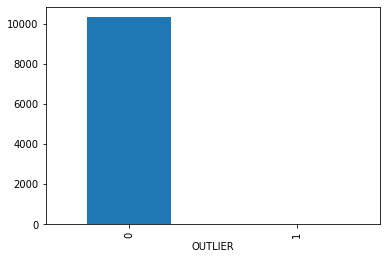

In [ ]:
taxi_df.groupby('OUTLIER').size().plot.bar()

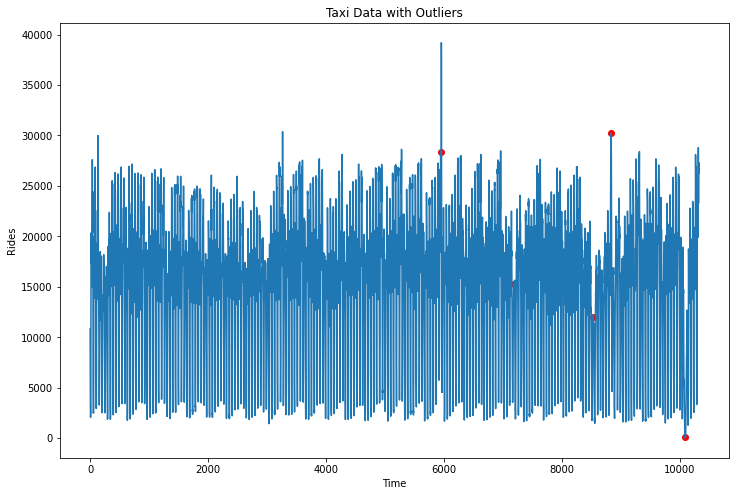

In [ ]:
taxi_df['VALUE'].plot(figsize=(12,8))
outliers_df = taxi_df[taxi_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

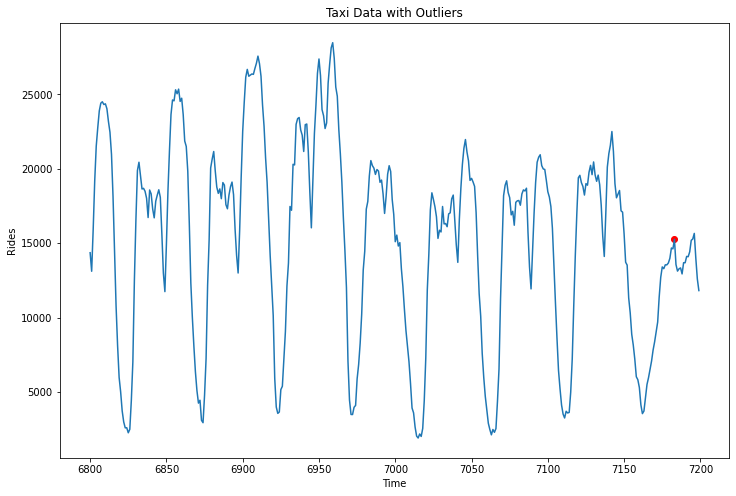

In [ ]:
subset_df = taxi_df[6800:7200]
subset_df['VALUE'].plot(figsize=(12,8))
outliers_df = subset_df[subset_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Helpers

In [ ]:
def plot_outliers(X, test, pred):
  df = X.copy()
  df['OUTLIER'] = test
  df['PRED']    = pred
  
  df['VALUE'].plot(figsize=(12,8))

  outliers_df = df[df.OUTLIER == 1]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
  outliers_df = df[(df.OUTLIER == 0) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red', marker='x') 
  outliers_df = df[(df.OUTLIER == 1) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='green');
  
  plt.xlabel('Time')
  plt.ylabel('Rides')
  plt.title('Taxi Data with Outliers');

def evaluate_outliers(X, y, pred):
  plot_outliers(X, y, pred)
  plot_confusion(y, pred)
  print_classification_report(y, pred)

def print_classification_report(test, pred, target_names=['NORMAL', 'OUTLIER']):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred, class_names=['NORMAL', 'OUTLIER']):
  cm = confusion_matrix(test, pred)
  df = pd.DataFrame(cm, class_names, class_names)
  plt.figure(figsize=(10, 10))
  sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plot_precision_recall_curve(test, pred_proba):
  precision, recall, _ = precision_recall_curve(test, pred_proba)
  aps = average_precision_score(y_test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(recall, precision, label=f'Avg Precision = {aps}')
  plt.plot([0,1], [0.5,0.5], linestyle='--')
  plt.fill_between(recall, 0, precision)
  plt.title('Precision Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc=4)
  plt.show()

# Preprocessing

In [ ]:
X_train = taxi_df.copy()
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])

# Evaluation Metrics
* Accuracy
* Precision
* Recall

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

# Hard Line
* Define a boundary line on the data (typically high / low)
* Above (or below) line is a classified as an outlier

In [ ]:
def score_hardline(values, upper, lower):
  outliers = np.where((values > lower) & (values < upper), 0, 1)
  return outliers

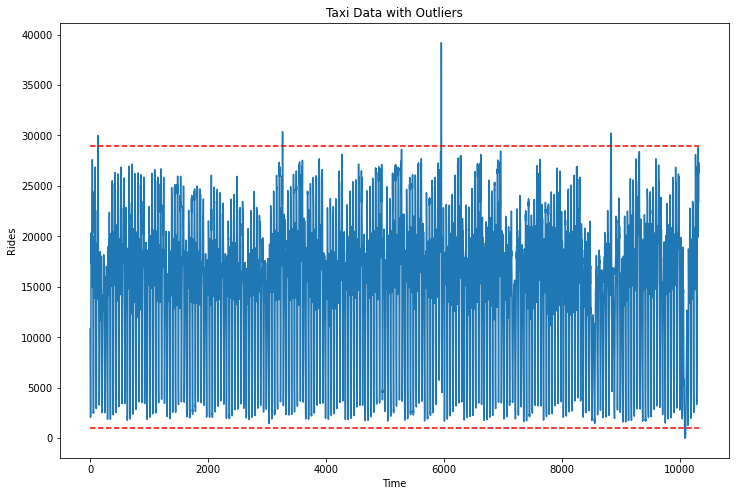

In [ ]:
UPPER = 29000
LOWER = 1000
taxi_df['VALUE'].plot(figsize=(12,8))
plt.plot([0, len(taxi_df)], [UPPER, UPPER], '--', color='red')
plt.plot([0, len(taxi_df)], [LOWER, LOWER], '--', color='red')

plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

Outliers Found 27


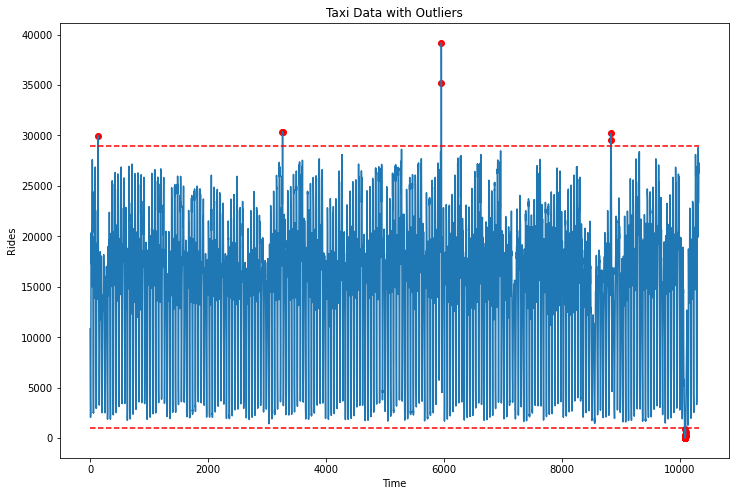

In [ ]:
hardline_df = taxi_df.copy()
hardline_df['SCORE'] = score_hardline(hardline_df['VALUE'], UPPER, LOWER)

print(f'Outliers Found {np.sum(hardline_df.SCORE)}')

hardline_df['VALUE'].plot(figsize=(12,8))
outliers_df = hardline_df[hardline_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');

plt.plot([0, len(taxi_df)], [UPPER, UPPER], '--', color='red')
plt.plot([0, len(taxi_df)], [LOWER, LOWER], '--', color='red')

plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

In [ ]:
hardline_df.head()

,TIMESTAMP,VALUE,OUTLIER,SCORE
0,2014-07-01 00:00:00,10844,0,0
1,2014-07-01 00:30:00,8127,0,0
2,2014-07-01 01:00:00,6210,0,0
3,2014-07-01 01:30:00,4656,0,0
4,2014-07-01 02:00:00,3820,0,0


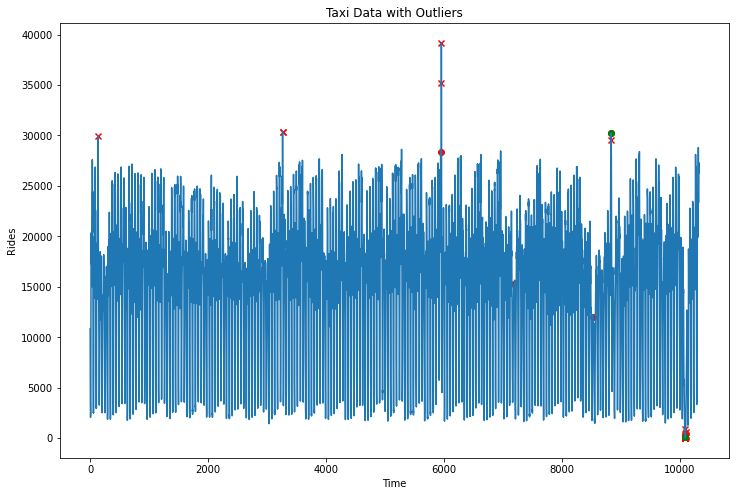

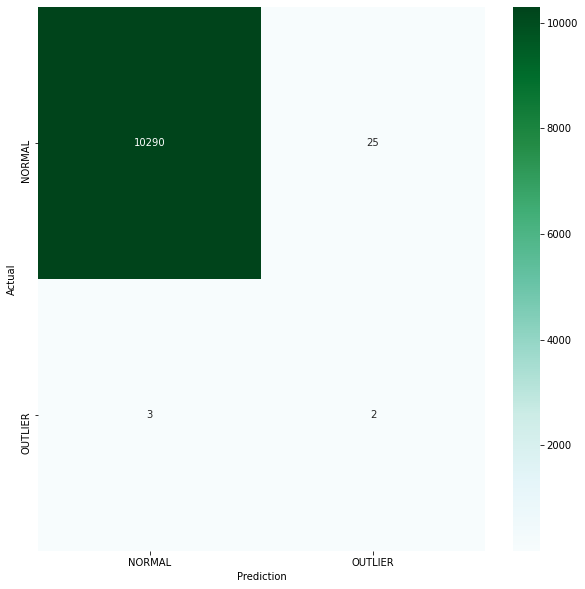

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     10315
     OUTLIER       0.07      0.40      0.12         5

    accuracy                           1.00     10320
   macro avg       0.54      0.70      0.56     10320
weighted avg       1.00      1.00      1.00     10320



In [ ]:
evaluate_outliers(hardline_df[['VALUE']], y_train, hardline_df.SCORE)

# IQR

## Full Dataset

In [ ]:
def model_iqr(values):
  q25, q75 = np.percentile(values, [25 ,75])
  iqr = q75 - q25
  low  = q25 - 1.5 * iqr
  high = q75 + 1.5 * iqr
  return iqr, q25, q75, low, high 

def score_iqr(values, lower, upper):
  outliers = np.where((values > lower) & (values < upper), 0, 1)
  return outliers

Outliers Found 2


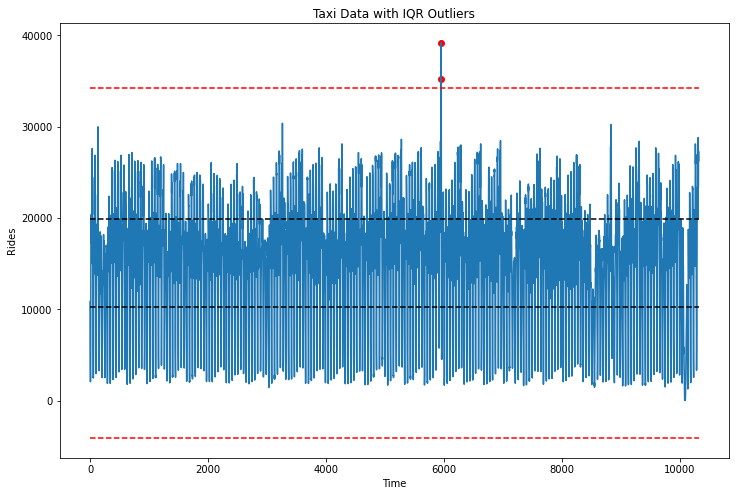

In [ ]:
iqr_df = taxi_df.copy()
iqr, q25, q75, iqr_lower, iqr_upper = model_iqr(iqr_df.VALUE)
iqr_df['SCORE'] = score_iqr(iqr_df['VALUE'], iqr_lower, iqr_upper)

print(f'Outliers Found {np.sum(iqr_df.SCORE)}')

iqr_df['VALUE'].plot(figsize=(12,8))
outliers_df = iqr_df[iqr_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');

plt.plot([0, len(taxi_df)], [q25, q25], '--', color='black')
plt.plot([0, len(taxi_df)], [q75, q75], '--', color='black')

plt.plot([0, len(taxi_df)], [iqr_upper, iqr_upper], '--', color='red')
plt.plot([0, len(taxi_df)], [iqr_lower, iqr_lower], '--', color='red')

plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with IQR Outliers');

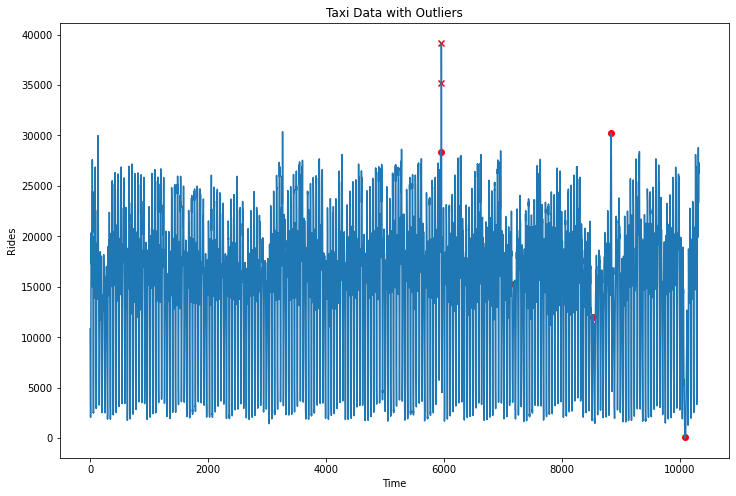

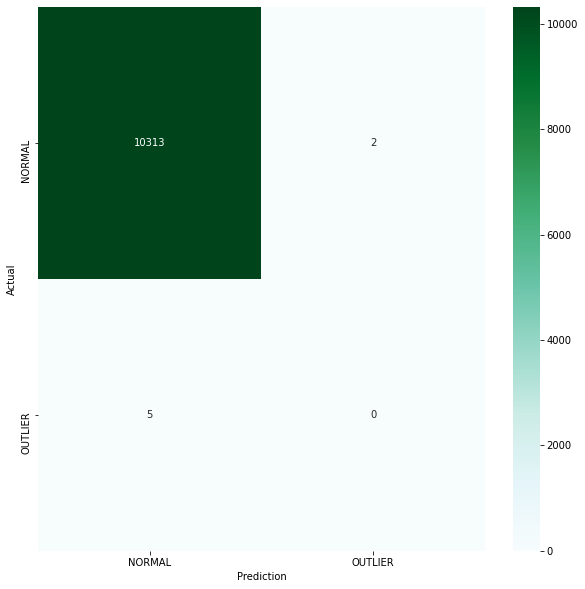

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     10315
     OUTLIER       0.00      0.00      0.00         5

    accuracy                           1.00     10320
   macro avg       0.50      0.50      0.50     10320
weighted avg       1.00      1.00      1.00     10320



In [ ]:
evaluate_outliers(iqr_df[['VALUE']], y_train, iqr_df.SCORE)

## Windowing

Outliers Found 91.0


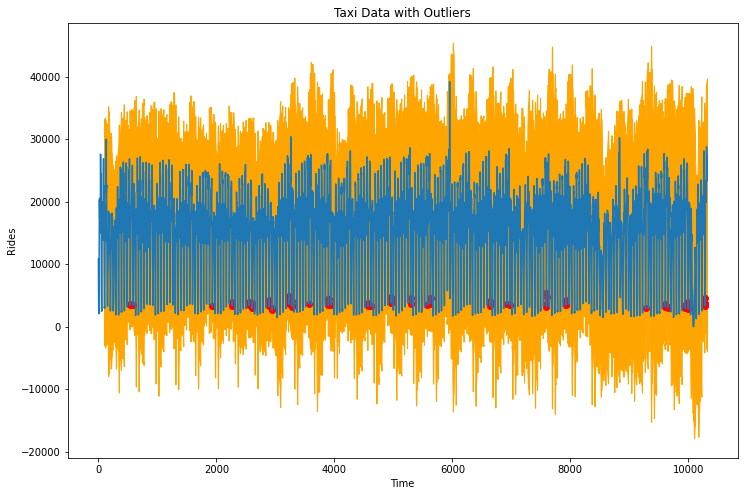

In [ ]:
WINDOW=96

window_iqr_df = taxi_df.copy()
window_iqr_df['THRESH_LOW']  = np.NaN
window_iqr_df['THRESH_HIGH'] = np.NaN
window_iqr_df['SCORE']       = np.NaN

for index in range(len(window_iqr_df) - WINDOW - 1):
  iqr, q25, q75, iqr_lower, iqr_upper = model_iqr(
      window_iqr_df.VALUE[index: index + WINDOW])
  
  scores = score_iqr(window_iqr_df.VALUE[index: index + WINDOW],
                     iqr_lower, iqr_upper)
  window_iqr_df.at[index + WINDOW - 1, 'SCORE'] = scores[-1]
  window_iqr_df.at[index + WINDOW - 1, 'THRESH_LOW']  = iqr_lower
  window_iqr_df.at[index + WINDOW - 1, 'THRESH_HIGH'] = iqr_upper

print(f'Outliers Found {np.sum(window_iqr_df.SCORE)}')

plt.figure(figsize=(12,8))
plt.plot(window_iqr_df['VALUE'])
outliers_df = window_iqr_df[window_iqr_df.SCORE == 1]
plt.fill_between(window_iqr_df.index, 
                 window_iqr_df.THRESH_LOW, 
                 window_iqr_df.THRESH_HIGH, color='orange')
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

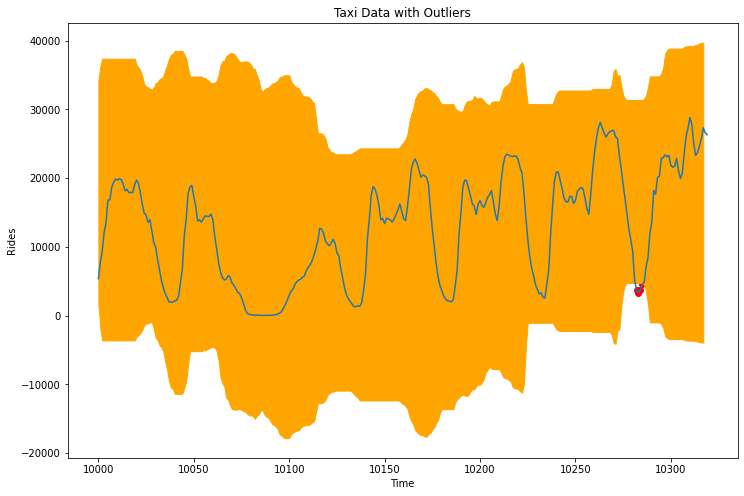

In [ ]:
FROM, TO = 10000, len(taxi_df)
plt.figure(figsize=(12,8))
plt.plot(window_iqr_df['VALUE'][FROM:TO])
outliers_df = window_iqr_df[FROM:TO][window_iqr_df[FROM:TO].SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.fill_between(window_iqr_df[FROM:TO].index, 
                 window_iqr_df[FROM:TO].THRESH_LOW, 
                 window_iqr_df[FROM:TO].THRESH_HIGH, 
                 color='orange')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Gaussian
* Hardlines 
  * Extremely easy to implement
  * They are hard to maintain in practice
  * Picking boundaries requires human interaction
  * Can't adapt to new "normal"
  * Can't handle seasonality
  * Require complexity to model trends (sloped lines)
* IQR 
  * Easy to implement & robust to outliers
  * Adapts to shape of the data
  * Limited statistical properties (like a "smart" hardline
* Gaussian
  * Given data, summarize the data with two properties
    * Mean (Central Tendency)
    * Variance (Dispersion)
  * Use helpful properties of the gaussian to identify outliers
  * 68, 95, 99.7 Rule
* Identify an outlier
  * Falls in the tail 
  * X deviations away from normal

![NormalCurve](https://cdn.kastatic.org/googleusercontent/WMk7638euFCSZxV_9Mv39CHE0RsUbrjnFAe1M7-Fk0HnwdMDjmJpTiC2Cj2CyNLAgWD1hJ1pTAI7uIAP4Zzx5n4)
  

In [ ]:
def gaussian(values):
  mean = np.mean(values)
  std  = np.std(values)
  return mean, std

def score_gaussian(values, tolerance=1.):
  mean, std = gaussian(values)
  low  = mean - std * tolerance
  high = mean + std * tolerance
  outliers = np.where((values > low) & (values < high), 0, 1)
  return outliers, mean, std, low, high

## Full Dataset
* Use the full training dataset to measure mean and standard deviation
* Decide on a threshold (X std deviations away)
* Flag datapoints outside the threshold as an anomaly

Mean 15137.569379844961 STD 6939.159584040666
Outliers Found 28


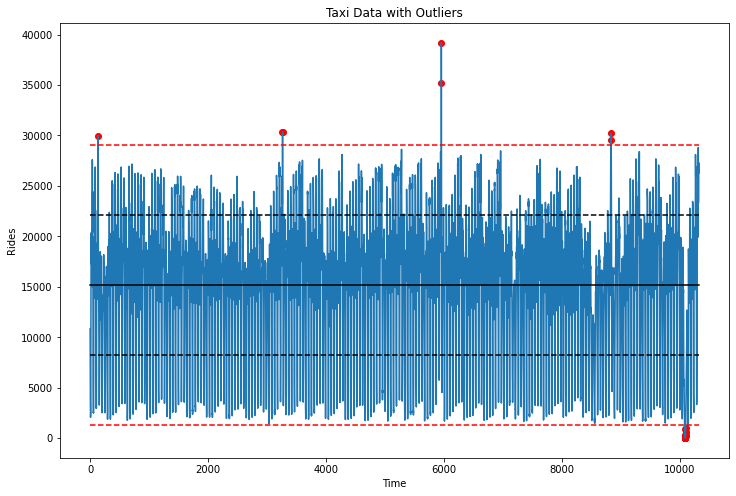

In [ ]:
TOLERANCE=2.
gaussian_df = taxi_df.copy()
mean, std = gaussian(gaussian_df.VALUE)
gaussian_df['SCORE'], _, _, _, _ = score_gaussian(gaussian_df['VALUE'], tolerance=TOLERANCE)

print(f'Mean {mean} STD {std}')
print(f'Outliers Found {sum(gaussian_df.SCORE)}')

gaussian_df['VALUE'].plot(figsize=(12,8))
outliers_df = gaussian_df[gaussian_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');

plt.plot([0, len(gaussian_df)], [mean, mean], '-', color='black')
plt.plot([0, len(gaussian_df)], [mean + std, mean + std], '--', color='black')
plt.plot([0, len(gaussian_df)], [mean + 2 * std, mean + 2 * std], '--', color='red')
plt.plot([0, len(gaussian_df)], [mean - std, mean - std], '--', color='black')
plt.plot([0, len(gaussian_df)], [mean - 2 * std, mean - 2 * std], '--', color='red')

plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

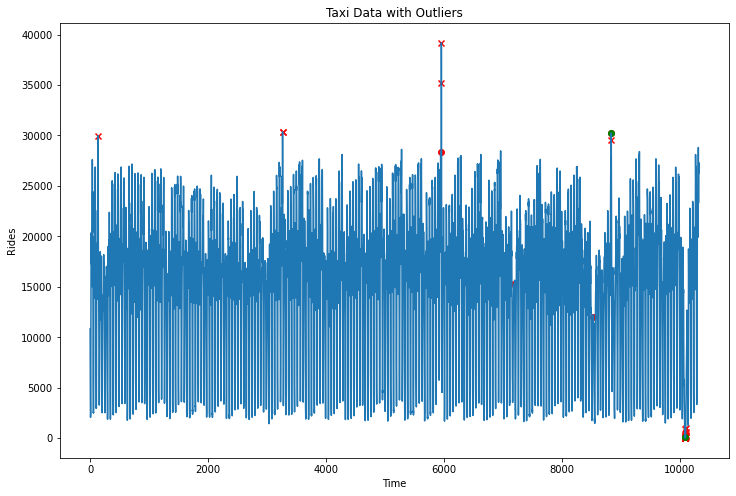

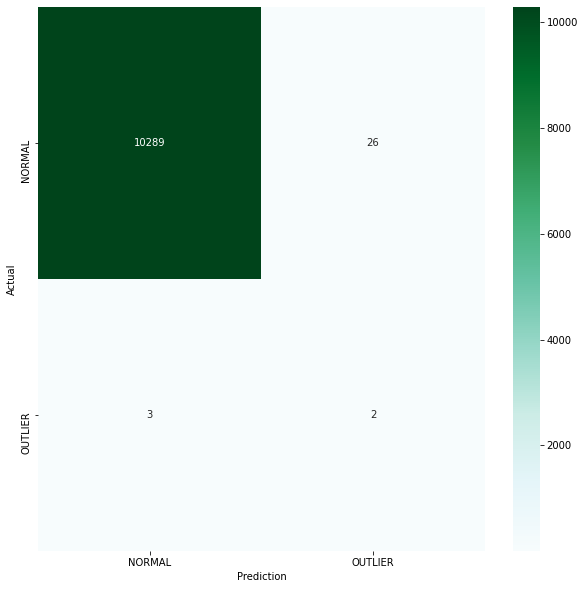

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     10315
     OUTLIER       0.07      0.40      0.12         5

    accuracy                           1.00     10320
   macro avg       0.54      0.70      0.56     10320
weighted avg       1.00      1.00      1.00     10320



In [ ]:
evaluate_outliers(gaussian_df[['VALUE']], y_train, gaussian_df.SCORE)

## Windowing
* Full Dataset
  * Our gaussian appears to find extreme points
  * You can think of it as an "intelligent" hard line
  * You still need to think about rejection region
  * It doesn't have any notion of periodicity
* Windowing Gaussian
  * Rather than use the full dataset, use a sliding window
  * This allows the filter to adapt to the data

Outliers Found 229.0


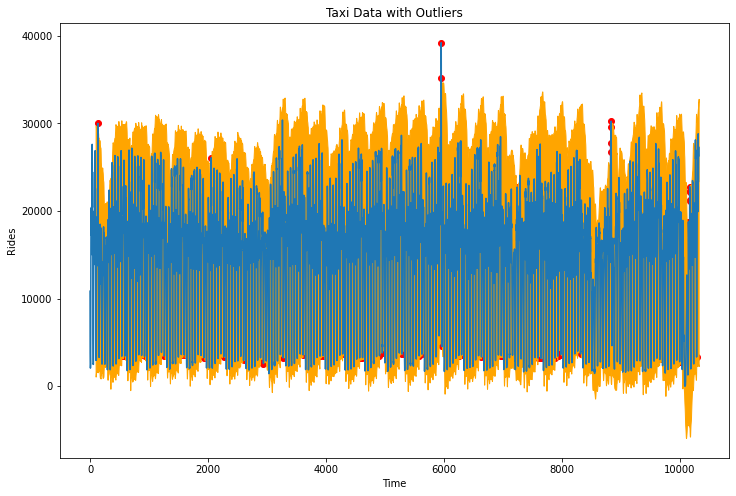

In [ ]:
WINDOW=96
TOLERANCE=2.
window_gaussian_df = taxi_df.copy()
window_gaussian_df['THRESH_LOW']  = np.NaN
window_gaussian_df['THRESH_HIGH'] = np.NaN
window_gaussian_df['SCORE']       = np.NaN

for index in range(len(window_gaussian_df) - WINDOW - 1):
  scores, mean, std, low, high = score_gaussian(
      window_gaussian_df.VALUE[index: index + WINDOW],
      tolerance=TOLERANCE)
  window_gaussian_df.at[index + WINDOW - 1, 'SCORE'] = scores[-1]
  window_gaussian_df.at[index + WINDOW - 1, 'THRESH_LOW']  = low
  window_gaussian_df.at[index + WINDOW - 1, 'THRESH_HIGH'] = high

print(f'Outliers Found {np.sum(window_gaussian_df.SCORE)}')

plt.figure(figsize=(12,8))
plt.plot(window_gaussian_df['VALUE'])
outliers_df = window_gaussian_df[window_gaussian_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.fill_between(window_gaussian_df.index, 
                 window_gaussian_df.THRESH_LOW, 
                 window_gaussian_df.THRESH_HIGH, color='orange')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

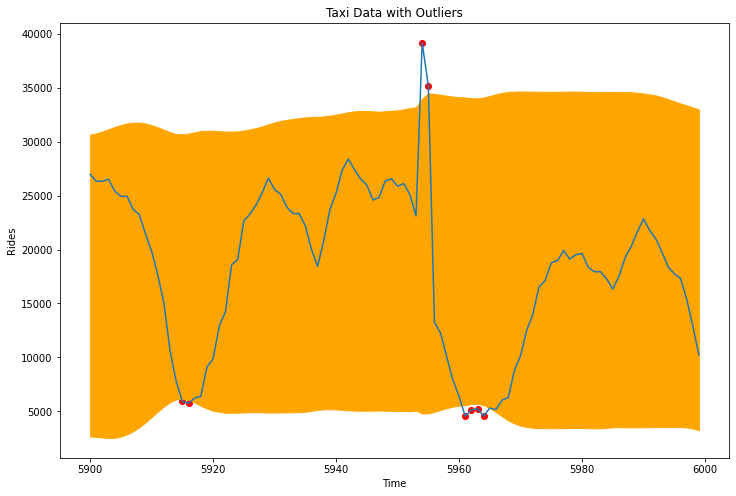

In [ ]:
FROM, TO = 5900, 6000
plt.figure(figsize=(12,8))
plt.plot(window_gaussian_df['VALUE'][FROM:TO])
outliers_df = window_gaussian_df[FROM:TO][window_gaussian_df[FROM:TO].SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.fill_between(window_gaussian_df[FROM:TO].index, 
                 window_gaussian_df[FROM:TO].THRESH_LOW, 
                 window_gaussian_df[FROM:TO].THRESH_HIGH, 
                 color='orange')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Median Absolute Difference
* Gaussians
  * There are several advantages
    * Easy to compute
    * Grounded in statistical theory
  * Disadvantages
    * Does the data fit the distribution?
      * Skew (3rd Moment)
      * Kurtosis (4th Moment) Heavy "tails"
    * Can't see anomalies within the acceptance region
    * Influenced by outliers
* Median Absolute Difference
  * MAD is an attempt to reduce the influence of outliers on our detector
  * The use of median rather than mean makes our approach robust to extreme values

In [ ]:
example = [1, 2, 3, 4, 5, 6, 100]
print(f'Mean {np.mean(example):.2f} Standard Deviation {np.std(example):.2f}')

Mean 17.29 Standard Deviation 33.80


In [ ]:
def median_abs_diff(values):
  med  = np.median(values)
  diff = np.abs(values - med)
  mad  = np.median(diff)
  return mad

def score_mad(values, tolerance=1.):
  mad = median_abs_diff(values)
  med = np.median(values)
  low  = med - mad * tolerance
  high = med + mad * tolerance
  outliers = np.where((values > low) & (values < high), 0, 1)
  return outliers, mad, low, high

## Full Dataset

Median 16778.0
Median Abs Diff 4088.0
Outliers Found 2906


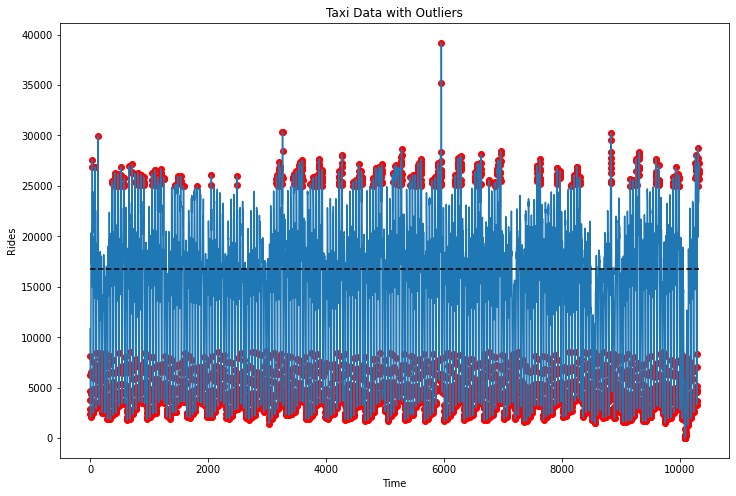

In [ ]:
TOLERANCE=2.
mad_df = taxi_df.copy()
med = np.median(mad_df.VALUE)
mad_df['SCORE'], _, _, _ = score_mad(mad_df['VALUE'], tolerance=TOLERANCE)

print(f'Median {med}')
print(f'Median Abs Diff {median_abs_diff(mad_df.VALUE)}')
print(f'Outliers Found {np.sum(mad_df.SCORE)}')

mad_df['VALUE'].plot(figsize=(12,8))
outliers_df = mad_df[mad_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.plot([0, len(mad_df)], [med, med], '--', color='black')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

## Windowing

Outliers Found 2805.0


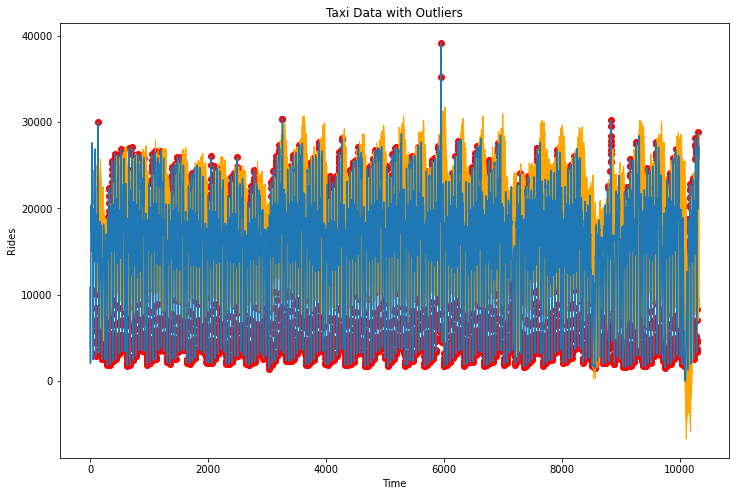

In [ ]:
WINDOW = 96
TOLERANCE = 2
window_mad_df = taxi_df.copy()
window_mad_df['THRESH_LOW']  = np.NaN
window_mad_df['THRESH_HIGH'] = np.NaN
window_mad_df['SCORE']       = np.NaN
for index in range(len(window_mad_df) - WINDOW - 1):
  scores, mad, low, high = score_mad(window_mad_df.VALUE[index : index + WINDOW], tolerance=TOLERANCE)
  window_mad_df.at[index + WINDOW - 1, 'SCORE'] = scores[-1]
  window_mad_df.at[index + WINDOW - 1, 'THRESH_LOW']  = low
  window_mad_df.at[index + WINDOW - 1, 'THRESH_HIGH'] = high

print(f'Outliers Found {np.sum(window_mad_df.SCORE)}')

plt.figure(figsize=(12,8))
plt.plot(window_mad_df['VALUE'])
outliers_df = window_mad_df[window_mad_df.SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.fill_between(window_mad_df.index, 
                 window_mad_df.THRESH_LOW, window_mad_df.THRESH_HIGH, color='orange')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

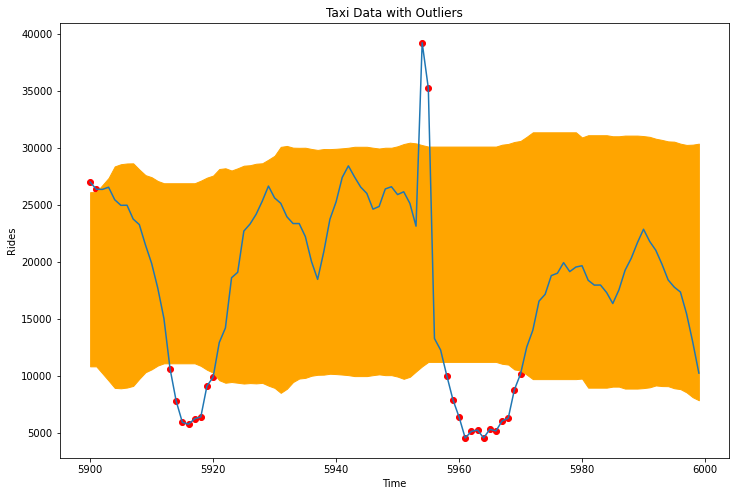

In [ ]:
FROM, TO = 5900, 6000
plt.figure(figsize=(12,8))
plt.plot(window_mad_df['VALUE'][FROM:TO])
outliers_df = window_mad_df[FROM:TO][window_mad_df[FROM:TO].SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.fill_between(window_mad_df[FROM:TO].index, 
                 window_mad_df[FROM:TO].THRESH_LOW, 
                 window_mad_df[FROM:TO].THRESH_HIGH, 
                 color='orange')
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');